In [42]:
# Model Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Metric imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef,cohen_kappa_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

# other
import pandas as pd
import joblib


In [43]:
# reading in data
X_train = pd.read_csv("../data/X_train.csv").to_numpy()
X_test = pd.read_csv("../data/X_test.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()

In [44]:
# getting scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
y_train[:3] # just checking

array([0, 0, 0])

In [46]:
def print_eval(y_test, y_hat):
    print("accuracy", accuracy_score(y_test, y_hat))
    print("F1", f1_score(y_test, y_hat))
    print("recall", recall_score(y_test, y_hat))
    print("precision", precision_score(y_test, y_hat))
    print("MCC", matthews_corrcoef(y_test, y_hat))
    print("Cohen's K", cohen_kappa_score(y_test, y_hat))

### Dummy

In [47]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_y = dummy.predict(X_val)

print_eval(y_val, dummy_y)

accuracy 0.5240963855421686
F1 0.0
recall 0.0
precision 0.0
MCC 0.0
Cohen's K 0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Anything with worse than 52% accuracy is really really bad

### Naive Bayes

In [49]:
# let's take a look at NB precision recall
nb = GaussianNB()
nb.fit(X_train, y_train) # doesn't need standardized X_train

GaussianNB()

In [76]:
Y_proba = nb.predict_proba(X_test)[:, 1] # Y_proba of positive class only

In [77]:
Y_proba

array([0.49857968, 0.84201858, 0.44863928, 0.48893497, 0.47469839,
       0.59802108, 0.51932196, 0.48799616, 0.20404537, 0.31718183,
       0.17756529, 0.35191217, 0.40099519, 0.84196494, 0.39453178,
       0.61877765, 0.36847768, 0.82506841, 0.4646831 , 0.56424957,
       0.23661505, 0.52505399, 0.437272  , 0.58151087, 0.65087316,
       0.47302783, 0.43177157, 0.38226066, 0.46074395, 0.44067206,
       0.38506045, 0.61239884, 0.39696189, 0.68048839, 0.21725801,
       0.18619409, 0.56253826, 0.58290528, 0.44759435, 0.16136849,
       0.35776008, 0.43630051, 0.44054221, 0.61319484, 0.59972548,
       0.41006558, 0.83548334, 0.81980028, 0.83548334, 0.51723304,
       0.38877607, 0.40738154, 0.23034088, 0.43968822, 0.39012743,
       0.49280063, 0.39603555, 0.46325263, 0.84225104, 0.54034697,
       0.53422168, 0.36056571, 0.86610453, 0.55187564, 0.3359398 ,
       0.86610453, 0.62485255, 0.52404843, 0.38529204, 0.563708  ,
       0.86610453, 0.38379423, 0.35471185, 0.20460349, 0.41105

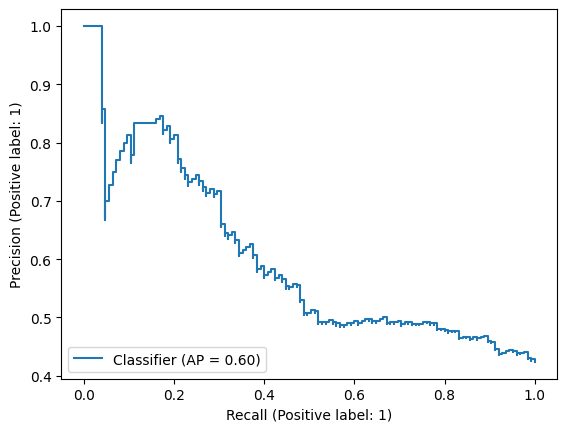

In [78]:
PrecisionRecallDisplay.from_predictions(y_test, Y_proba)

In [61]:
# 1.0 recall also gives us a reasonable precision

In [62]:
# Naive Bayes does not need tuning

In [63]:
# let's take a look at NB precision recall
nb = GaussianNB()
nb.fit(X_train, y_train) # doesn't need standardized X_train
y_pred = nb.predict(X_test)
print_eval(y_test, y_pred)

accuracy 0.6169491525423729
F1 0.5150214592274678
recall 0.48
precision 0.5555555555555556
MCC 0.20273892631890095
Cohen's K 0.20126991733556965


### Logistic Regression

In [66]:
# will need to do this a lot
def get_best_model_params(model, params):
    gs_clf = GridSearchCV(estimator=model(),
                     param_grid=params,
                     cv=20,
                     verbose=0,
                     scoring='recall')

    gs_clf.fit(X_train_scaled, y_train)

    # training the model using the best params
    bp = gs_clf.best_params_
    print(f"Best parameters found {bp}")
    return bp

In [69]:
# some combinations are not possible, so fine-tuning the LR takes some work

# In terms of solvers, it looks like liblinear and newton-cholesky are the only ones that make sense
# Liblinear is good for small datasets, while newton-cholesky is good when n_samples > n_features, per sklearn docs


# First, let's find the best functioning model for the liblinear solver
logistic_params = {"solver": ["liblinear"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l1", "l2"]}

best_params = get_best_model_params(LogisticRegression, logistic_params)
liblinear_model = LogisticRegression(**best_params)
liblinear_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = liblinear_model.predict(X_test_scaled)
print_eval(y_test, y_pred)

Best parameters found {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy 0.7084745762711865
F1 0.635593220338983
recall 0.6
precision 0.6756756756756757
MCC 0.3960081103291501
Cohen's K 0.3940769047050394


In [70]:
# But what about with newton-cholesky?
logistic_params = {"solver": ["newton-cholesky"],
    "C": [1.0, 0.1, 0.01, 0.001, 0.0001],
    "penalty": ["l2"]}


best_params = get_best_model_params(LogisticRegression, logistic_params)
newton_cholesky_model = LogisticRegression(**best_params)
newton_cholesky_model.fit(X_train_scaled, y_train)

# looking at test here
y_pred = newton_cholesky_model.predict(X_test_scaled)

print_eval(y_test, y_pred)

Best parameters found {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cholesky'}
accuracy 0.711864406779661
F1 0.5933014354066987
recall 0.496
precision 0.7380952380952381
MCC 0.4013997704589625
Cohen's K 0.3832246956093962


In [71]:
# Other solvers don't make sense to investigate. Let's look at precision-recall for liblinear_model. It did better on Recall, the target metric

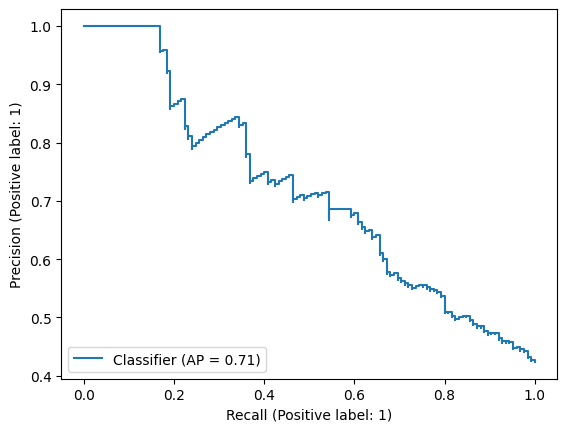

In [75]:
Y_prob_preds = liblinear_model.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

### Support Vector Machine

In [ ]:
SVC_params = {"C": [1.0, 0.1, 0.01, 0.001, 0.0001],
             "gamma": ["scale", "auto"], 
             "degree": [1, 2, 3, 4], 
             "kernel": ["linear", "poly", "rbf", "sigmoid"]}
best_params = get_best_model_params(SVC, SVC_params)
svc_model = SVC(**best_params)
svc_model.fit(X_train_scaled)

y_pred = svc_model.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = svc_model.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

### Decision Tree Classifier

In [ ]:
DT_params = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 3, 5, 7, 9]
    }
best_paramst_params = get_best_modelDecisionTreeClassifierrams(DecisionTree, DT_params)
DT = DecisionTree(**best_params)
DT.fit(X_train_scaled)

y_pred = DT.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = DT.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)

### Random Forest

In [ ]:
RF_params = {
        "n_estimators": [25, 50, 100, 150],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 3, 5, 7, 9]
}
best_params = get_best_model_params(RandomForest, RF_params)
RF = RandomForest(**best_params)
RF.fit(X_train_scaled)

y_pred = RF.predict(X_test_scaled)
print_eval(y_test, y_pred)

Y_prob_preds = RF.predict_proba(X_test_scaled)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, Y_prob_preds)